#### Loading required libraries

In [1]:
import torch
import torchvision # provide access to datasets, models, transforms, utils, etc
import torchvision.transforms as transforms
import numpy as np
import matplotlib.pyplot as plt
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import Dataset
import random


torch.set_grad_enabled(True)

In [2]:
test_set = torchvision.datasets.MNIST(
    root='./data',
    train=False,
    download=True,
    transform = transforms.Compose([
          transforms.ToTensor()
    ])
)

  0%|          | 0/9912422 [00:00<?, ?it/s]

Extracting ./data/MNIST/raw/train-images-idx3-ubyte.gz to ./data/MNIST/raw



  0%|          | 0/28881 [00:00<?, ?it/s]

Extracting ./data/MNIST/raw/train-labels-idx1-ubyte.gz to ./data/MNIST/raw



  0%|          | 0/1648877 [00:00<?, ?it/s]

Extracting ./data/MNIST/raw/t10k-images-idx3-ubyte.gz to ./data/MNIST/raw



  0%|          | 0/4542 [00:00<?, ?it/s]

Extracting ./data/MNIST/raw/t10k-labels-idx1-ubyte.gz to ./data/MNIST/raw



/usr/local/lib/python3.7/dist-packages/torchvision/datasets/mnist.py:498: UserWarning: The given NumPy array is not writeable, and PyTorch does not support non-writeable tensors. This means you can write to the underlying (supposedly non-writeable) NumPy array using the tensor. You may want to copy the array to protect its data or make it writeable before converting it to a tensor. This type of warning will be suppressed for the rest of this program. (Triggered internally at  /pytorch/torch/csrc/utils/tensor_numpy.cpp:180.)
  return torch.from_numpy(parsed.astype(m[2], copy=False)).view(*s)


In [3]:
train_set = torchvision.datasets.MNIST(
    root='./data',
    train=True,
    download=True,
    transform = transforms.Compose([
          transforms.ToTensor()
    ])
)

#### Building Model

In [4]:
class Network(nn.Module):
  def __init__(self):
    super().__init__()
    self.conv1 = nn.Conv2d(in_channels=1, out_channels=16, kernel_size=5) 
    self.conv2 = nn.Conv2d(in_channels=16, out_channels=32, kernel_size=5)
    self.fc1 = nn.Linear(in_features=32 * 4 * 4, out_features=120)
    
    self.out1 = nn.Linear(in_features=120, out_features=10)
    self.out2 = nn.Linear(in_features=20, out_features=19)
  
  def forward(self, image, rand_num):
    # input layer
    x = image

    # conv1 layer
    x = self.conv1(x)
    x = F.relu(x)
    x = F.max_pool2d(x, kernel_size=2, stride=2) 

    # conv2 layer
    x = self.conv2(x)
    x = F.relu(x)
    x = F.max_pool2d(x, kernel_size=2, stride=2) 


    # reshapre
    x = x.reshape(-1, 32 * 4 * 4)

    # fc1 layer
    x = self.fc1(x)
    x = F.relu(x)


    # output layer
    x = self.out1(x)
    sum_out = torch.cat((x, rand_num), dim=1)
    sum_out = self.out2(sum_out)
    return x, sum_out

In [5]:
def get_default_device():
    """
    Pick GPU if available, else CPU.
    """
    if torch.cuda.is_available():
        return torch.device('cuda')
    else:
        return torch.device('cpu')

device = get_default_device()
device

device(type='cuda')

In [6]:
network = Network()

#### Move model to CPU

In [7]:
network.to(device)

Network(
  (conv1): Conv2d(1, 16, kernel_size=(5, 5), stride=(1, 1))
  (conv2): Conv2d(16, 32, kernel_size=(5, 5), stride=(1, 1))
  (fc1): Linear(in_features=512, out_features=120, bias=True)
  (out1): Linear(in_features=120, out_features=10, bias=True)
  (out2): Linear(in_features=20, out_features=19, bias=True)
)

### Create Dataset

In [9]:
class MNISTRandDataset(Dataset):
    def __init__(self, mnist):
        self.mnist = mnist

    def __len__(self):
        return len(self.mnist)

    def __getitem__(self, idx):
        image, label = self.mnist[idx]

        rand_num = random.randint(0, 9)

        rand_num_tensor = F.one_hot(torch.tensor(rand_num), num_classes=10)
        sum_label = label + rand_num

        return image, rand_num_tensor, label, sum_label

In [10]:
def get_num_correct(img_out, labels, sum_out, sum_label):
  return img_out.argmax(dim=1).eq(labels).sum().item(), sum_out.argmax(dim=1).eq(sum_label).sum().item()

In [11]:
train_ds = MNISTRandDataset(train_set)
test_ds = MNISTRandDataset(test_set)

In [12]:
train_loader = torch.utils.data.DataLoader(train_ds, batch_size=100)
optimizer = optim.Adam(network.parameters(), lr=0.01)

archive = []

for epoch in range(100):

    result = {}
    total_loss = 0
    total_correct_image = 0
    total_correct_sum = 0

    for batch in train_loader: # Get Batch
        images, rand_num_tensor, labels, sum_label = batch 
        images, rand_num_tensor, labels, sum_label = images.to(device), rand_num_tensor.to(device), labels.to(device), sum_label.to(device)

        img_out, sum_out = network(images, rand_num_tensor) # Pass Batch

        loss1 = F.cross_entropy(img_out, labels) # Calculate Loss
        loss2 = F.cross_entropy(sum_out, sum_label) # Calculate Loss
        loss = loss1 + loss2

        optimizer.zero_grad()
        loss.backward() # Calculate Gradients
        optimizer.step() # Update Weights

        total_loss += loss.item()
        correct_image, correct_sum = get_num_correct(img_out, labels, sum_out, sum_label)
        total_correct_image += correct_image
        total_correct_sum += correct_sum

    result['total_correct_image_accuracy'] = total_correct_image/len(train_set)
    result['total_correct_sum_accuracy'] = total_correct_sum/len(train_set)
    result['epoch'] = epoch
    result['loss'] = total_loss
    archive.append(result)   

    print(
        "epoch", epoch, 
        "total_correct_image_accuracy:", result['total_correct_image_accuracy'], 
        "total_correct_sum_accuracy:", result['total_correct_sum_accuracy'], 
        "loss:", total_loss
    )

/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:718: UserWarning: Named tensors and all their associated APIs are an experimental feature and subject to change. Please do not use them for anything important until they are released as stable. (Triggered internally at  /pytorch/c10/core/TensorImpl.h:1156.)
  return torch.max_pool2d(input, kernel_size, stride, padding, dilation, ceil_mode)


epoch 0 total_correct_image_accuracy: 0.96225 total_correct_sum_accuracy: 0.28573333333333334 loss: 1234.6857355833054
epoch 1 total_correct_image_accuracy: 0.9858333333333333 total_correct_sum_accuracy: 0.40346666666666664 loss: 931.7045692205429
epoch 2 total_correct_image_accuracy: 0.9885166666666667 total_correct_sum_accuracy: 0.4681666666666667 loss: 835.7943940162659
epoch 3 total_correct_image_accuracy: 0.99085 total_correct_sum_accuracy: 0.5134333333333333 loss: 767.4515199661255
epoch 4 total_correct_image_accuracy: 0.9917166666666667 total_correct_sum_accuracy: 0.5531 loss: 718.6924607753754
epoch 5 total_correct_image_accuracy: 0.9927333333333334 total_correct_sum_accuracy: 0.5792666666666667 loss: 681.2113049030304
epoch 6 total_correct_image_accuracy: 0.9935 total_correct_sum_accuracy: 0.6121333333333333 loss: 648.8068004846573
epoch 7 total_correct_image_accuracy: 0.9943666666666666 total_correct_sum_accuracy: 0.6411 loss: 615.1315823197365
epoch 8 total_correct_image_acc

In [13]:
test_loader = torch.utils.data.DataLoader(test_ds, batch_size=100)

total_correct_image = 0
total_correct_sum = 0


for batch in test_loader:  
    images, rand_num_tensor, labels, sum_label = batch 

    images, rand_num_tensor, labels, sum_label = images.to(device), rand_num_tensor.to(device), labels.to(device), sum_label.to(device)

    img_out, sum_out = network(images, rand_num_tensor) 

    correct_image, correct_sum = get_num_correct(img_out, labels, sum_out, sum_label)
    total_correct_image += correct_image
    total_correct_sum += correct_sum

print(
    "total_correct_image:", total_correct_image,
    "total_correct_sum:", total_correct_sum
)

total_correct_image: 9849 total_correct_sum: 9219


In [17]:
print(f'Image recognition accuracy: {total_correct_image/len(test_set)} , Sum Prediction accuracy: {total_correct_sum/len(test_set)}')

Image recognition accuracy: 0.9849 , Sum Prediction accuracy: 0.9219


### Plot Accuracy Vs Epoch Graph

In [15]:
def plot_accuracies(history):
    total_correct_image_accuracy = [x['total_correct_image_accuracy'] for x in history]
    total_correct_sum_accuracy = [x['total_correct_sum_accuracy'] for x in history]
    plt.figure(figsize=(12, 8))
    plt.plot(total_correct_image_accuracy, '-x')
    plt.plot(total_correct_sum_accuracy, '-x')
    plt.xlabel('epoch')
    plt.ylabel('accuracy')
    plt.legend(['digit_recognition_accuracy', 'sum_prediction_accuracy'])
    plt.title('Accuracy vs. No. of epochs')
    plt.savefig('Accuracy.png');

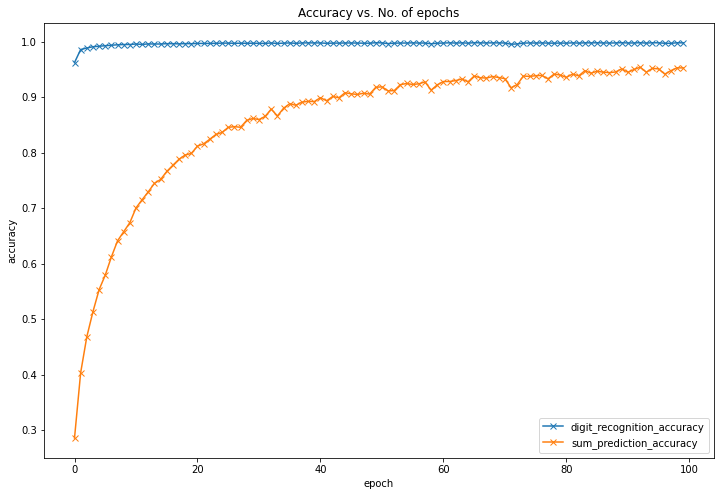

In [16]:
plot_accuracies(archive)